In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import random

Using matplotlib backend: Qt5Agg


In [2]:
import gillespy2
from gillespy2.basic_root_solver import BasicRootSolver
from gillespy2.basic_ssa_solver import BasicSSASolver
from gillespy2.basic_hybrid_solver import BasicHybridSolver

Unable to use Cython optimized SSA:
Error:Building module gillespy2.cython_ssa_solver failed: ['distutils.errors.DistutilsPlatformError: Unable to find vcvarsall.bat\n']


In [308]:
class MichaelisMenten(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Michaelis_Menten")
            
            #parameters
            rate1 = gillespy2.Parameter(name='rate1', expression= 0.000017)
            rate2 = gillespy2.Parameter(name='rate2', expression= 0.005)
            rate3 = gillespy2.Parameter(name='rate3', expression = 0.001)
            self.add_parameter([rate1,rate2,rate3])
            
            #Species
            A = gillespy2.Species(name='A', initial_value=100)
            B = gillespy2.Species(name='B', initial_value=100)
            C = gillespy2.Species(name='C', initial_value=100)
            D = gillespy2.Species(name='D', initial_value=100)
            #DET = gillespy2.Species(name='DET', initial_value=1) #Create a deterministic species
            #Deterministic species will be a regular species, but with "deterministic" flag
            DET = gillespy2.Species(name='DET', initial_value=0, deterministic=True)
            self.add_species([A, B, C, D, DET])
            
            #rate_rules
            rate_rule1 = gillespy2.RateRule(name='rate_rule1', expression="math.sin(t)", species=DET)
            self.add_rate_rule(rate_rule1)
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={C:1},
                   rate=rate1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={C:1}, products={A:1,B:1},
                    rate=rate2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={B:1,D:1},
                    rate=rate3)
            r4 = gillespy2.Reaction(name="r4", reactants={C:1}, products={D:1}, propensity_function="rate2*A*DET/vol")
            #r4 uses a deterministic species result as an argument
            self.add_reaction([r1,r2,r3, r4])
            self.timespan(numpy.linspace(0,100,101))

In [309]:
model = MichaelisMenten()
print(model.listOfRateRules)

Adding rate rule  <gillespy2.gillespy2.RateRule object at 0x000001E35C67CEB8>  to  Michaelis_Menten
OrderedDict([('rate_rule1', <gillespy2.gillespy2.RateRule object at 0x000001E35C67CEB8>)])


In [310]:
def func(y, t, pops, species, parameters, reactions, rate_rules):
    curr_state = {'vol':1}
    state_change = []
    for i, s in enumerate(species):
        curr_state[s] = pops[i]
        if model.listOfSpecies[s].deterministic:
            curr_state[s] = y[i]
    #curr_state['DET'] = y[4] #Override population for deterministic species with current pop
    #this will require knowing the index of the deterministic species in y
    for p in parameters:
        curr_state[p] = parameters[p].value
    for i, r in enumerate(reactions):
        state_change.append(eval(reactions[r].propensity_function, curr_state))
    for i, rr in enumerate(rate_rules):
        state_change.append(eval(rate_rules[rr].expression))
    #state_change.append(eval("math.sin(t)"))  #This is the deterministic rate (RateRules) to append in a loop
    return state_change

In [311]:
for i, r in enumerate(model.listOfReactions):
    print(model.listOfReactions[r].propensity_function)
for i, rr in enumerate(model.listOfRateRules):
    print(model.listOfRateRules[rr].expression)

rate1*A*B/vol
rate2*C
rate3*C
rate2*A*DET/vol
math.sin(t)


In [312]:
t = numpy.linspace(0, .1, 11)
num_deterministic = 0
for i, s in enumerate(model.listOfSpecies):
    if model.listOfSpecies[s].deterministic:
        num_deterministic += 1
y0 = [0] * (len(model.listOfReactions)+num_deterministic) # +1 for deterministic species
#HERE, we will add +num_det_species which will be collected at species creation
populations = []
propensities = {}
curr_state = {}
curr_time = 0
curr_state['vol'] = 1
save_time = 0
end_time = t[-1]
results = {'time': []}
test_count = 0


for s in model.listOfSpecies:
    # initialize populations
    populations.append(model.listOfSpecies[s].initial_value)
    curr_state[s] = model.listOfSpecies[s].initial_value
    results[s] = []

for p in model.listOfParameters:
    curr_state[p] = model.listOfParameters[p].value

#print(curr_time)
#print(end_time)
#while curr_time < end_time:
test_count += 1
propensity_sum = 0
for i, r in enumerate(model.listOfReactions):
    y0[i] = (math.log(random.uniform(0, 1)))
    propensities[r] = eval(model.listOfReactions[r].propensity_function, curr_state)
    propensity_sum += propensities[r]
#y0[4] = 1 #Get value of deterministic species
#First time, sets to initial value, after that...curr_state? 
#This would be a for loop capturing all deterministic species
for i, s in enumerate(model.listOfSpecies):
    if model.listOfSpecies[s].deterministic:
        y0[i] = curr_state[s]
if propensity_sum <= 0:
    while save_time <= end_time:
        results['time'].append(save_time)
        for s in model.listOfSpecies:
            results[s].append(curr_state[s])
        save_time += increment

In [313]:
print(y0)
t2= numpy.linspace(0, 10, 101)

[-1.2245254998252852, -1.472705595506266, -1.593669162756439, -0.56856992269637, 0]


In [314]:
y = odeint(func, y0, t2, args=(populations, model.listOfSpecies, model.listOfParameters, model.listOfReactions, model.listOfRateRules))

In [315]:
rx1 = y[:,0]
rx2 = y[:,1]
rx3 = y[:,2]
rx4 = y[:,3] # Reaction including Deterministic Species
det = y[:,4] # Determinisitc Species

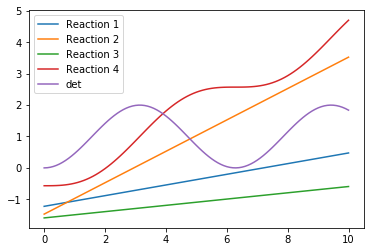

In [316]:
plt.plot(t2, rx1, label="Reaction 1")
plt.plot(t2, rx2, label="Reaction 2")
plt.plot(t2, rx3, label="Reaction 3")
plt.plot(t2, rx4, label="Reaction 4")
plt.plot(t2, det, label="det")
plt.legend(loc="best")

In [317]:
results = model.run(solver=BasicHybridSolver(), show_labels=True)
print(results)

Save time at beginning of get reaction:  0
Int Time:  0.1
Reaction Fired:  [None, -0.14488102371618983, -0.1850101197616883, -0.712629903482477, -0.07966069142820907, 0.0, 0]
Save time:  0  Curr Time:  0
Save time at beginning of get reaction:  1.0
Int Time:  0.1
Int Time:  0.2
Int Time:  0.30000000000000004
Int Time:  0.4
Int Time:  0.5
Int Time:  0.6
Int Time:  0.7
Int Time:  0.7999999999999999
Int Time:  0.8999999999999999
Int Time:  0.9999999999999999
Int Time:  1.0999999999999999
Reaction Fired:  [None, -1.3632963908925362, -0.34385176556918257, -0.010399573778001717, -1.9416294442230604, 0.45969769794480786, 1.0]
Save time:  1.0  Curr Time:  1.0
Save time at beginning of get reaction:  2.0
Int Time:  1.1
Int Time:  1.2000000000000002
Int Time:  1.3000000000000003
Int Time:  1.4000000000000004
Int Time:  1.5000000000000004
Int Time:  1.6000000000000005
Int Time:  1.7000000000000006
Int Time:  1.8000000000000007
Int Time:  1.9000000000000008
Int Time:  2.000000000000001
Reaction Fi

Save time at beginning of get reaction:  36.0
Int Time:  34.70000000000001
Int Time:  34.80000000000001
Int Time:  34.90000000000001
Int Time:  35.000000000000014
Int Time:  35.100000000000016
Int Time:  35.20000000000002
Reaction Fired:  ['r4', -0.7059376961397933, -1.3974460156653412, -0.7663331708167365, 0.02731124666416279, 4.023470195540699, 35.20000000000002]
Save time:  36.0  Curr Time:  35.20000000000002
Save time at beginning of get reaction:  37.0
Int Time:  35.30000000000002
Int Time:  35.40000000000002
Int Time:  35.50000000000002
Int Time:  35.60000000000002
Int Time:  35.700000000000024
Int Time:  35.800000000000026
Int Time:  35.90000000000003
Reaction Fired:  ['r4', -0.9959293744886197, -0.036528702211122366, -1.6190282319432916, 0.021454376619176596, 3.4491919390188444, 35.90000000000003]
Save time:  37.0  Curr Time:  35.90000000000003
Save time at beginning of get reaction:  37.0
Int Time:  36.00000000000003
Reaction Fired:  ['r4', -1.223546157403164, -0.0425120724397

Reaction Fired:  ['r4', -1.0030712851734027, -0.11305993552667121, -0.2713274698438011, 0.1756994763843514, 4.1436166091950515, 61.700000000000124]
Save time:  63.0  Curr Time:  61.700000000000124
Save time at beginning of get reaction:  63.0
Int Time:  61.800000000000125
Int Time:  61.90000000000013
Int Time:  62.00000000000013
Int Time:  62.10000000000013
Int Time:  62.20000000000013
Int Time:  62.30000000000013
Int Time:  62.400000000000134
Int Time:  62.500000000000135
Int Time:  62.600000000000136
Int Time:  62.70000000000014
Int Time:  62.80000000000014
Int Time:  62.90000000000014
Int Time:  63.00000000000014
Reaction Fired:  ['r4', -0.40735872023041825, -0.2625119579197738, -2.2265416687393076, 0.11787708760932977, 3.771003254094756, 63.0]
Save time:  63.0  Curr Time:  63.0
Save time at beginning of get reaction:  64.0
Int Time:  63.1
Int Time:  63.2
Reaction Fired:  ['r2', -2.2165688912394947, 0.0046046232035799935, -1.233260982587107, -3.6372626896598663, 3.8239056007665417, 

Int Time:  88.04999999999954
Int Time:  88.14999999999954
Int Time:  88.24999999999953
Int Time:  88.34999999999953
Int Time:  88.44999999999952
Int Time:  88.54999999999951
Int Time:  88.64999999999951
Reaction Fired:  ['r4', -0.551518554748732, -1.2414408997964832, -0.5186296922917285, 0.032634184513764, 3.349795986002811, 88.64999999999951]
Save time:  89.0  Curr Time:  88.64999999999951
Save time at beginning of get reaction:  90.0
Int Time:  88.7499999999995
Int Time:  88.8499999999995
Int Time:  88.94999999999949
Int Time:  89.04999999999949
Int Time:  89.14999999999948
Int Time:  89.24999999999947
Int Time:  89.34999999999947
Int Time:  89.44999999999946
Int Time:  89.54999999999946
Int Time:  89.64999999999945
Int Time:  89.74999999999945
Int Time:  89.84999999999944
Int Time:  89.94999999999943
Int Time:  90.04999999999943
Reaction Fired:  [None, -1.0041483267170905, -2.7662471078997637, -0.2846915905159123, -0.31819955219359863, 4.572038729629419, 90.0]
Save time:  90.0  Curr

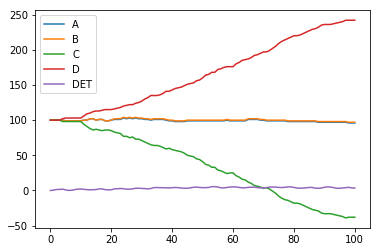

In [318]:
plt.plot(results['time'], results['A'], label='A')
plt.plot(results['time'], results['B'], label='B')
plt.plot(results['time'], results['C'], label='C')
plt.plot(results['time'], results['D'], label='D')
plt.plot(results['time'], results['DET'], label='DET')
plt.legend(loc='best')

In [319]:
print(results)

{'time': [0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0], 'A': [100, 100, 100, 100, 100, 99, 99, 99, 99, 99, 99, 100, 100, 102, 102, 100, 101, 101, 99, 99, 100, 101, 101, 101, 103, 102, 103, 102, 103, 102, 102, 101, 101, 100, 101, 101, 101, 101, 100, 99, 99, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 99, 99, 99, 99, 99, 99, 101, 101, 101, 101, 100, 100, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98

In [320]:
results = model.run(solver=BasicRootSolver(), show_labels=True)

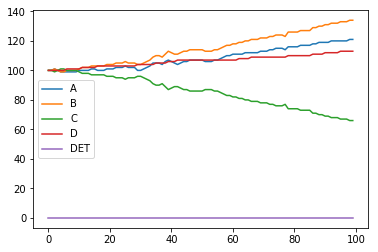

In [321]:
plt.plot(results['time'], results['A'], label='A')
plt.plot(results['time'], results['B'], label='B')
plt.plot(results['time'], results['C'], label='C')
plt.plot(results['time'], results['D'], label='D')
plt.plot(results['time'], results['DET'], label='DET')
plt.legend(loc='best')

In [290]:
print(results)

{'time': [0, 0.009999999999999787, 0.019999999999999574, 0.02999999999999936, 0.03999999999999915, 0.049999999999998934, 0.05999999999999872, 0.06999999999999851, 0.0799999999999983, 0.08999999999999808, 0.09999999999999787, 0.10999999999999766, 0.11999999999999744, 0.12999999999999723, 0.13999999999999702, 0.1499999999999968, 0.1599999999999966, 0.16999999999999638, 0.17999999999999616, 0.18999999999999595, 0.19999999999999574, 0.20999999999999552, 0.2199999999999953, 0.2299999999999951, 0.23999999999999488, 0.24999999999999467, 0.25999999999999446, 0.26999999999999424, 0.27999999999999403, 0.2899999999999938, 0.2999999999999936, 0.3099999999999934, 0.3199999999999932, 0.32999999999999297, 0.33999999999999275, 0.34999999999999254, 0.3599999999999923, 0.3699999999999921, 0.3799999999999919, 0.3899999999999917, 0.3999999999999915, 0.40999999999999126, 0.41999999999999105, 0.42999999999999083, 0.4399999999999906, 0.4499999999999904, 0.4599999999999902, 0.46999999999999, 0.479999999999989